# 9. Hypothesis Testing

In this chapter, we will look at hypothesis testing in R. We will start with single sample distributions and tests, and then we will look at hypothesis tests when comparing two samples. Examples will include testing for positive correlations, performing two sample paired t-tests, and testing for equal variance among groups. The data we will use in this section comes from the Texas Health and Human Services Department and includes the reported number of induced terminations of pregnancy (ITOPs) from 2016 to 2021, stratified by both race and county. The data also contains the rate of abortions per 1000 females aged 15-49. Read the data documentation to see the full variable descriptions.

In [1]:
library(tidyverse)
library(car)
library(RforHDSdata)
library(gt)
library(gtsummary)
data(tex_itop)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: carData




Attaching package: ‘car’




The following object is masked from ‘package:dplyr’:

    recode




The following object is masked from ‘package:purrr’:

    some




## Univariate Distributions and One Sample Tests

Let's begin by looking at a single outcome of interest - the number of induced terminations of pregnancy (referred to as ITOPs or abortions below) in 2021 per 1000 females ages 15-49 in each county. We use the number of females ages 15-49 as a proxy to scale the number of abortions by the population size, though this is not truly reflective of the number of people who can give birth in each county. 

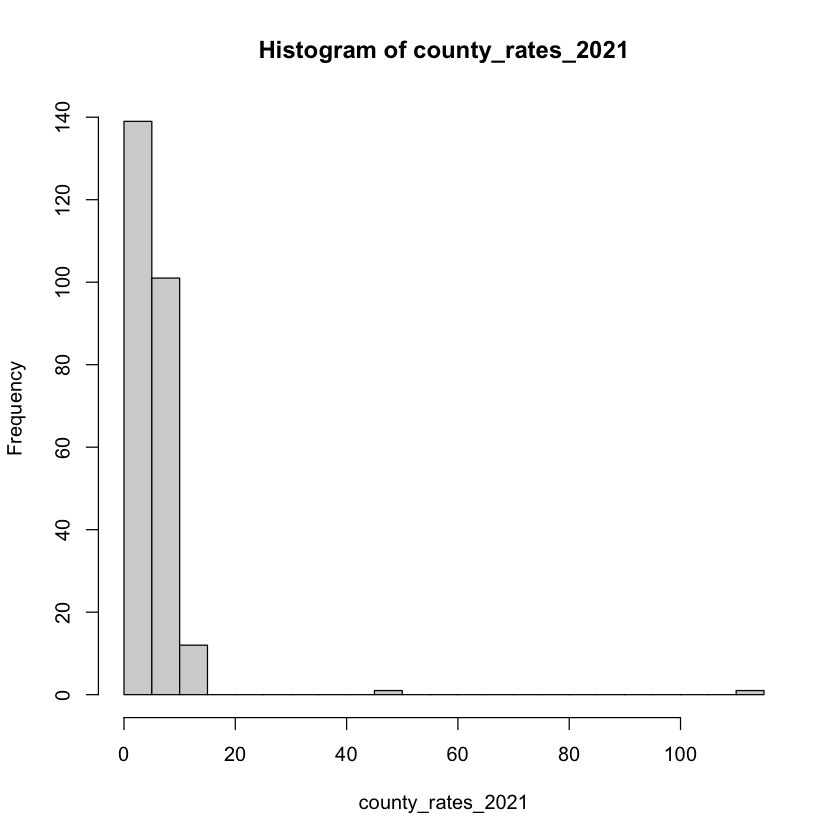

In [2]:
county_rates_2021 <- tex_itop$total_rate[tex_itop$year == 2021]
hist(county_rates_2021, breaks = 35)

We can see in the figure that this is a heavy-tailed distribution. Below, we find the 10 counties with highest rates and see that there are some counties with very few total abortions but that have some of the highest abortion rates. This indicates a small population. On the other hand, we also observe Harris county, which contains the city of Houston and has both a high total abortion count and a high abortion rate. 

In [3]:
tex_itop %>% 
  filter(year==2021) %>% 
  slice_max(n=10, total_rate) %>%
  dplyr::select(c(county, total_itop, total_rate))

county,total_itop,total_rate
<chr>,<dbl>,<dbl>
Loving,1,111.11111
Terrell,5,50.00000
Concho,4,13.88889
Harris,14122,13.49705
Irion,3,12.93103
Real,4,12.50000
Bexar,5180,11.91413
Menard,3,11.76471
Dallas,6867,11.72197


Some of the counties are so small that we may want to consider dropping them from our analysis. In particular, the rates in Loving County and Terrel County are so high that we might consider them to be outliers. For this one sample analysis, however, we do not remove them. If we wanted to estimate the mean abortion rate among counties $\mu$ we can do so by simply using the `mean()` function. For reference, the [CDC](https://www.cdc.gov/reproductivehealth/data_stats/abortion.htm) reported the national abortion rate to be 11.2 abortions per 1,000 women aged 15–44 years.

In [4]:
mean(county_rates_2021, na.rm=TRUE)

[1] 5.166244

Within R we can also calculate a confidence interval for this mean. Recall that a $(1-\alpha)$%  confidence interval for the mean is given by the equation below, where $\hat{\mu}$ is our sample mean, $\hat{\sigma}^2$ is the sample variance, and $n$ is the number of observations.
$$\hat{\mu} \pm z_{1-\alpha/2} \cdot \frac{\hat{\sigma}}{\sqrt{n}}$$

Below, we use this formula to calculate a 95% confidence interval for the mean abortion rate among counties:

In [5]:
est_mean <- mean(county_rates_2021, na.rm=TRUE)
est_sd <- sd(county_rates_2021)
z_alpha <- dnorm(1-0.05/2)
n <- length(county_rates_2021)
c(est_mean - z_alpha*est_sd/sqrt(n), est_mean + z_alpha*est_sd/sqrt(n))

[1] 5.043713 5.288775

If we want to display this nicely, we can use the `round()` function, which allows us to specify a number of digits to be displayed, and the `paste()` function, which creates a single character string from multiple inputs. 

In [6]:
lower <- round(est_mean - z_alpha*est_sd/sqrt(n),3)
upper <- round(est_mean + z_alpha*est_sd/sqrt(n),3)
paste("Confidence Interval: (", lower, ",", upper, ")")

[1] "Confidence Interval: ( 5.044 , 5.289 )"

Suppose that we wanted to run a hypothesis test to compare the mean to a pre-determined value. In particular, the Texas Heartbeat Act was introduced in 2021 and drastically reduced the number of eligible abortions. We could test whether there were significantly fewer abortions in 2021 compared to 2020. Our null hypothesis is that $\mu \geq 6.23$, the mean abortion rate in 2020. To run this hypothesis test, we use the `t.test()` function. For a one sample t-test, we need to specify our sample `x`, the alternative hypothesis `alternative` (default is a two-sided test), the true value of the mean `mu` (default 0), and a confidence level `conf.level` (default 0.95). Below, we run this t-test, and we can see from the result that we reject the null hypothesis and observe a statistically significant difference in the mean abortion rate between 2020 and 2021. 

In [7]:
t.test(county_rates_2021, alternative = "less", mu = 6.23, conf.level=0.95)


	One Sample t-test

data:  county_rates_2021
t = -2.1532, df = 253, p-value = 0.01612
alternative hypothesis: true mean is less than 6.23
95 percent confidence interval:
     -Inf 5.981853
sample estimates:
mean of x 
 5.166244 


One thing to consider is that the `t.test()` function assumes that the sample `x` comes from a normal distribution. The one-sample Wilcoxon signed rank test is a non-parametric alternative to the one-sample t-test that can be used to compare the median value of a sample to a theoretical value without assuming that the data is normally distributed. This test can be performed using the `wilcox.test()` function and takes in the same arguments as the `t.test()` function. Below, we can see that we again reject the null hypothesis and conclude that the mean abortion rate in 2021 was significantly lower than that of 2020.

In [8]:
wilcox.test(county_rates_2021, alternative = "less", mu = 6.23, conf.level=0.95)


	Wilcoxon signed rank test with continuity correction

data:  county_rates_2021
V = 7452, p-value = 4.38e-14
alternative hypothesis: true location is less than 6.23


## Correlation and Covariance

We now look at two sample tests. To start, we look at the 2020 and 2021 rates by county. We pivot our data into a wider format in order to create 2020 and 2021 rate columns, and, this time, we filter out the Loving and Terrel counties to remove outliers. We then create a scatter plot of 2021 vs 2020 rates and observe a linear correlation between the two.

In [9]:
county_rates <- tex_itop %>%
  dplyr::select(c(county, total_rate, year)) %>%
  filter(!(county %in% c("Terrell", "Loving")), year %in% c(2020, 2021)) %>%
  pivot_wider(names_from = year, values_from = total_rate) %>%
  na.omit() %>%
  rename("y2020"="2020", "y2021"="2021")
head(county_rates)

county,y2020,y2021
<chr>,<dbl>,<dbl>
Anderson,6.840638,5.0671396
Andrews,1.847453,0.7917656
Angelina,5.810719,5.9961674
Aransas,3.435353,7.1830106
Archer,1.465201,0.7326007
Armstrong,0.000000,0.0000000


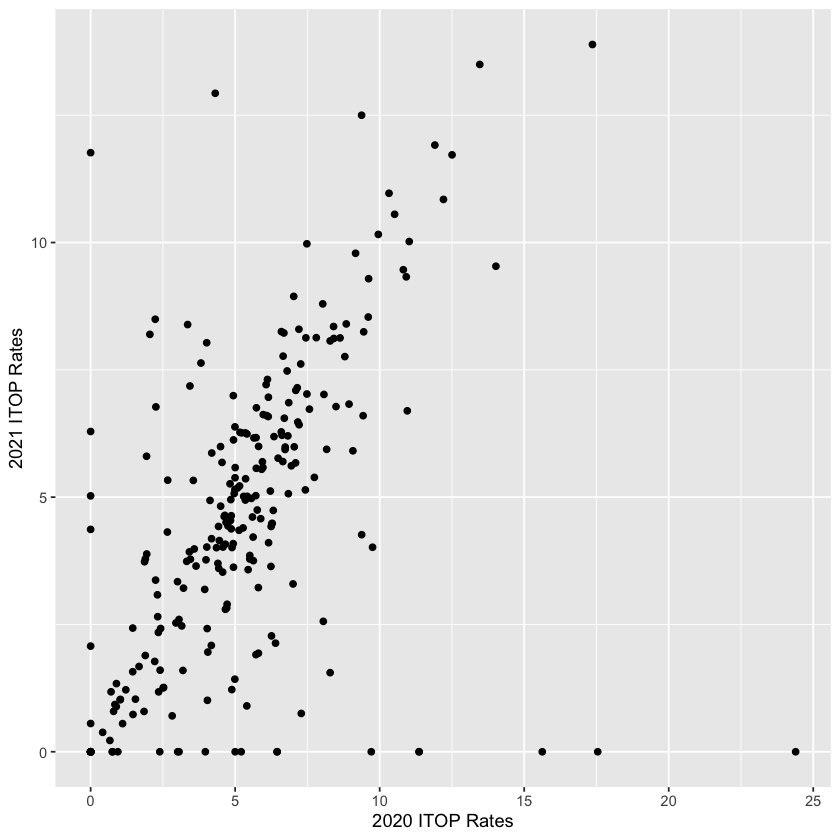

In [10]:
ggplot(county_rates) + 
 geom_point(aes(x=y2020,y=y2021)) +
 labs(x="2020 ITOP Rates", y="2021 ITOP Rates")

We have seen before how to calculate the correlation between two columns using the `cor()` function. We can also calculate the covariance using the `cov()` function. As suspected, there is a strong correlation. The estimated covariance is around 5.19.

In [11]:
cor(county_rates$y2020, county_rates$y2021)
cov(county_rates$y2020, county_rates$y2021)

[1] 0.4995677

[1] 5.198533

Besides calculating the value of the correlation, we can also test whether this correlation is significantly different from zero. The function `cor.test()` tests for association between paired samples, using either Pearson's product moment correlation coefficient, Kendall's $\tau$, or Spearman's $\rho$. Similar to the `t.test()` and `wilcox.test()` functions, we can also specify the `alternative` and `conf.level` arguments. Below, we test whether there is a non-zero correlation between the 2020 and 2021 county rates using Pearson's product-moment correlation. We can see from the resulting p-value that we can reject the null hypothesis that the correlation is zero and conclude that it is instead significantly different than zero. 

In [12]:
cor.test(county_rates$y2020, county_rates$y2021, method="pearson")


	Pearson's product-moment correlation

data:  county_rates$y2020 and county_rates$y2021
t = 9.1182, df = 250, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4007334 0.5869089
sample estimates:
      cor 
0.4995677 


## Two Sample Tests for Continuous Variables

If we wanted to directly compare the difference between 2020 and 2021 rates, we could use a two sample test. In this case, because our samples are paired by county, we can use a two sample paired t-test. Specifically, we use a two-sided test to test the null hypothesis that the rates are equal by specifying two different vectors `x` and `y`. Note that we used the default values of `mu=0` and `alternative="two.sided"`. Additionally, we used the default value `var.equal=FALSE`, which implies that the samples may have different variances. From the results below, we reject the null hypothesis that the two county rates are equal. 

In [13]:
t.test(x=county_rates$y2020, y=county_rates$y2021)


	Welch Two Sample t-test

data:  county_rates$y2020 and county_rates$y2021
t = 2.4693, df = 496.93, p-value = 0.01387
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1453563 1.2775189
sample estimates:
mean of x mean of y 
 5.279354  4.567916 


In the `tex_itop` dataset, each county has also been categorized by whether it was urban or rural. Suppose we want to compare the change in abortion rates from 2020 to 2021 between rural and urban counties. First, we create a variable describing the rate change between these years using the code below. We choose to use the change in rate rather than percent change to avoid infinite or undefined values.

In [14]:
county_rates_urban <- tex_itop %>%
  dplyr::select(c(county, urban, total_rate, year)) %>%
  filter(total_rate < 15, year %in% c(2020, 2021)) %>%
  pivot_wider(names_from = year, values_from = total_rate) %>%
  na.omit() %>%
  rename("y2020"="2020", "y2021"="2021") %>%
  mutate(rate_change = (y2021-y2020)) 

We again use a two-sample two-sided t-test, but this time the data is not paired. Below, we show an alternative way to specify a t-test test below using a formula `lhs ~ rhs`, where `lhs` is a numeric vector and `rhs` is a factor variable with two levels. We must also specify the data in this case. From the R output in this case, we would fail to reject the null hypothesis and conclude that the rate changes for urban and rural counties are not significantly different. 

In [15]:
t.test(rate_change~urban, data=county_rates_urban)


	Welch Two Sample t-test

data:  rate_change by urban
t = 0.1268, df = 205.36, p-value = 0.8992
alternative hypothesis: true difference in means between group Rural and group Urban is not equal to 0
95 percent confidence interval:
 -0.4950663  0.5631197
sample estimates:
mean in group Rural mean in group Urban 
         -0.4685861          -0.5026127 


Besides a t-test, we can also use a two-sample Wilcoxon non-parametric test using the `wilcox.test()` function, which has the same arguments as the function `t.test()`. Both the `t.test()` and `wilcox.test()` can only compare two groups. When we want to compare two or more independent samples, we can use a Kruskal-Wallis rank sum test using the `kruskal.test()` function or a one-way analysis of variance (ANOVA) using the `aov()` function. Even though we only have two groups in our example, we show how to run the corresponding tests for these two groups below. For the `kruskal.test()` function, we can either specify the arguments `formula` and `data` or we can specify two vectors: `x`, a numeric vector, and `g`, a factor representing the group. For the `aov()` function, we specify the test using a formula and then specify the data. To see the p-value, we have to use the `summary()` function to print the result. Again, both tests suggest that we fail to reject the null hypothesis.

In [16]:
kruskal.test(county_rates_urban$rate_change, county_rates_urban$urban)


	Kruskal-Wallis rank sum test

data:  county_rates_urban$rate_change and county_rates_urban$urban
Kruskal-Wallis chi-squared = 0.053698, df = 1, p-value = 0.8167


In [17]:
aov_res <- aov(rate_change~urban, data=county_rates_urban)
summary(aov_res)

             Df Sum Sq Mean Sq F value Pr(>F)
urban         1    0.1   0.053   0.008  0.927
Residuals   246 1553.3   6.314               

We could also test the variance of a continous variable between two groups using an F test. Our null hypothesis for this test is that the variance in both groups is equal. The function `var.test()` implements an F test and has the same main arguments as the `t.test()` function: vectors `x` and `y` OR a `formula` and `data`, the alternative hypothesis `alternative`, and `conf.level`. Additionally, we can specify the hypothesized ratio of the variances through the arugment `ratio` (default value 1). Note that this function assumes that the two samples come from normally distributed populations.

In [18]:
var.test(y2021 ~ urban, county_rates_urban)


	F test to compare two variances

data:  y2021 by urban
F = 1.117, num df = 187, denom df = 59, p-value = 0.6307
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.7194388 1.6566899
sample estimates:
ratio of variances 
          1.116952 


Lastly, we can consider Levene's test to test whether group variances are equal when there are more than two groups. This test can be specified using a formula and data set, as below, or by providing two vectors `y`, a numeric vector, and `g`, a vector specifying the groups. 

In [19]:
leveneTest(y2021 ~ as.factor(urban), county_rates_urban)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,1.474947,0.2257313
,246,NA,NA


## Two Sample Tests for Categorical Variables

In the two sample tests above, we were comparing the distributions of continuous variables. We now look at comparing distributions of categorical variables. We will first categorize counties by their abortion rate in 2020 being above or below 11.2, which was the national average rate that year. We display the distribution of this variable by the urban/rural grouping using a contingency table below.

In [20]:
county_rates_urban$below_nat_avg <- ifelse(county_rates_urban$y2020 > 11.2, "Above Nat Avg", "Below Nat Avg")
table(county_rates_urban$below_nat_avg, county_rates_urban$urban)

               
                Rural Urban
  Above Nat Avg     3     4
  Below Nat Avg   185    56

We can use a Fisher's exact test to test the distribution in this contingency table. The `fisher.test()` function can either take in a contingency table as a matrix or can be specified by two factor vectors `x` and `y`. Additionally, there is the option to specify the `alternative` and `conf.level` arguments. Again, we do not see a significant difference between urban and rural counties.

In [21]:
fisher.test(county_rates_urban$below_nat_avg, county_rates_urban$urban)


	Fisher's Exact Test for Count Data

data:  county_rates_urban$below_nat_avg and county_rates_urban$urban
p-value = 0.06063
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.03253238 1.39553277
sample estimates:
odds ratio 
  0.228734 


An alternative test is a Pearson's Chi-Squared test, which can be used for large sample sizes. The counts of rural and  urban counties in the 'Above Nat Avg' category are very small, so we recategorize our outcome to be at or above Texas's average to avoid this complication. The `chisq.test()` function also takes in a contingency table as a matrix or can be specified by two factor vectors `x` and `y`. Another useful argument is `correct` (default is TRUE) which indicates whether to apply a continuity correction. 

In [22]:
tex_mean <- mean(county_rates_urban$y2020)
county_rates_urban$below_tex_avg <- ifelse(county_rates_urban$y2020 > tex_mean, 
                                           "Above Texas Ave", "Below Texas Ave")
table(county_rates_urban$below_tex_avg, county_rates_urban$urban)

                 
                  Rural Urban
  Above Texas Ave    84    39
  Below Texas Ave   104    21

In [23]:

chisq.test(county_rates_urban$below_tex_avg, county_rates_urban$urban)


	Pearson's Chi-squared test with Yates' continuity correction

data:  county_rates_urban$below_tex_avg and county_rates_urban$urban
X-squared = 6.7212, df = 1, p-value = 0.009527


## Adding Hypothesis Tests to Summary Tables

Earlier, we used the `gt` and `gtsummary` packages to create summary tables of variables. When creating a stratified table (done by add the `by` argument), we can automatically add p-values for hypothesis tests comparing across populations using the `add_p()` function. By default, the `add_p()` function uses a Kruskal-Wallis rank sum test for continuous variables (or a Wilcoxon rank sum test when the `by` variable has two levels) and uses a Chi-Squared Contingency Table Test for categorical variables (or a Fisher's Exact Test for categorical variables with any expected cell count less than five). The chosen test(s) are dispalyed as footnotes.

In [24]:
tbl_summary(tex_itop, include = c(total_rate, white_rate, asian_rate, hispanic_rate, 
                                  black_rate, native_american_rate),
           by = "year", statistic = list(all_continuous() ~ "{mean} ({sd})")) %>% 
  add_p() %>%
  as_gt() %>% 
  gt:::as.tags.gt_tbl()

Shiny tags cannot be represented in plain text (need html)

## Exercises

Use different data and ask to recreate summary table p-values